## **1.  필요한 패키지 임포트 하기 **

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from tensorflow.keras.utils import plot_model

## **2. 데이터읽어오기 **

In [ ]:
enrolled = pd.read_csv("enrolleds_210729.csv")
#hw = pd.read_csv("./sparta_csv/enrolleds_homeworks_210729.csv")
user_data = pd.read_csv("prequestions_210729.csv")
#rounds = pd.read_csv("./sparta_csv/rounds_210729.csv")
course = pd.read_csv("courses_210729.csv")

print(user_data.shape)
print(enrolled.shape)
print(course.shape)

(48708, 6)
(39979, 7)
(50, 2)


In [ ]:
user_data.describe()

,age
count,4.870800e+04
mean,3.757061e+04
std,5.386966e+05
min,0.000000e+00
25%,2.400000e+01
50%,2.800000e+01
75%,3.400000e+01
max,2.009043e+07


In [ ]:
enrolled.describe()

,is_registered
count,16503.000000
mean,0.906441
std,0.291223
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
course.describe()

,course_id,title
count,50,50
unique,50,50
top,bdd218f17ec6313b96f3,웹개발 종합반
freq,1,1


## **유저데이터  전처리하기  **

In [ ]:
####유저데이터확인
user_data.head()

,user_id,course_id,round_id,job,age,gender
0,2397731931fe978eb349,bdd218f17ec6313b96f3,655f288f4382b12fd3d9,직장인,30.0,남
1,5eb42ddf1cda5ff826f2,bdd218f17ec6313b96f3,655f288f4382b12fd3d9,창업/사업,34.0,남
2,012a9585146a4ddc9f29,bdd218f17ec6313b96f3,655f288f4382b12fd3d9,직장인,32.0,여
3,347cba891997ca61b13e,cf06e86a19be34ec1e78,736c6b3d15fe95f501f8,창업/사업,34.0,여
4,caa3368273ce3b330b3e,cf06e86a19be34ec1e78,736c6b3d15fe95f501f8,대학생,23.0,남


In [ ]:
# 컬럼값 보기
user_data.job.unique()

array(['직장인', '창업/사업', '대학생', '무직/준비중', '기타', '학생', nan], dtype=object)

In [ ]:
####포맷맞추기 

user_data = user_data[['user_id','job','age','gender']]
user_data['job'] = user_data['job'].replace({'2. 직장인':'직장인', '4. 무직/준비중':'무직/준비중', '1. 학생':'학생',
                                            '5. 기타':'기타','3. 창업/사업' : '창업/사업'})


In [ ]:
user_data.job.unique()

array(['직장인', '창업/사업', '대학생', '무직/준비중', '기타', '학생', nan], dtype=object)

In [ ]:
user_data.head()

,user_id,job,age,gender
0,2397731931fe978eb349,직장인,30.0,남
1,5eb42ddf1cda5ff826f2,창업/사업,34.0,남
2,012a9585146a4ddc9f29,직장인,32.0,여
3,347cba891997ca61b13e,창업/사업,34.0,여
4,caa3368273ce3b330b3e,대학생,23.0,남


In [ ]:
####데이터 중 불필요하거나 유효하지 않은 데이터 삭제하는 과정 

#중복제거 
user_data=user_data.drop_duplicates(subset='user_id', keep='first', inplace=False)
#100세이상 제거 
user_data=user_data[user_data['age']<100]

In [ ]:
print(len(user_data.user_id.unique()))
user_data.head()

33737


,user_id,job,age,gender
0,2397731931fe978eb349,직장인,30.0,남
1,5eb42ddf1cda5ff826f2,창업/사업,34.0,남
2,012a9585146a4ddc9f29,직장인,32.0,여
3,347cba891997ca61b13e,창업/사업,34.0,여
4,caa3368273ce3b330b3e,대학생,23.0,남


In [ ]:
user_data.shape

(33737, 4)

## Enroll 데이터전처리하기 

In [ ]:
###Enroll 데이터확인

enrolled.head()
enroll_data = enrolled[['course_id', 'user_id', 'is_registered']]
enroll_data.head()

,course_id,user_id,is_registered
0,bdd218f17ec6313b96f3,2151609483dab408339c,1
1,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,0
2,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,0
3,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,0
4,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,0


In [ ]:
enroll_data.shape

(16503, 3)

In [ ]:
##유저데이터가 있는 interaction 데이터만 추출 
enroll_data=enroll_data[enroll_data["user_id"].isin(list(user_data.user_id.unique()))]

In [ ]:
enroll_data.shape

(12494, 3)

In [ ]:
enroll_data=enroll_data.drop_duplicates(subset=None, keep='first', inplace=False)

In [ ]:
enroll_data.shape

(11997, 3)

In [ ]:
enroll_data.head()

,course_id,user_id,is_registered
1,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,0
3,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,0
7,bdd218f17ec6313b96f3,80c1857389ec2d56928f,1
10,bdd218f17ec6313b96f3,a9899ce51cdd8a6264af,1
13,bdd218f17ec6313b96f3,ba56f3de9b03501c6651,1


In [ ]:
enroll_data.describe()

,is_registered
count,11997.000000
mean,0.932900
std,0.250206
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


## Course 데이터전처리하기 

In [ ]:
course.head()

,course_id,title
0,bdd218f17ec6313b96f3,웹개발 종합반
1,cf06e86a19be34ec1e78,앱개발 종합반
2,8e02dc4b2b82e9a15e1e,파이썬 데이터분석 첫걸음
3,d08d0754e8d4eec3862b,이미지처리로 시작하는 딥러닝
4,c6de4714a96cce9afe82,엑셀보다 쉬운 SQL


In [ ]:

course2 = pd.read_csv("courses_210729_v2.csv")
course2.head()


,course_id,app,level
0,bdd218f17ec6313b96f3,웹,종합
1,cf06e86a19be34ec1e78,앱,종합
2,8e02dc4b2b82e9a15e1e,파이썬,초급
3,d08d0754e8d4eec3862b,파이썬,종합
4,c6de4714a96cce9afe82,SQL,초급


## **없는 데이터 만들어내기   **

In [ ]:
import random 
unique_user = list(user_data.user_id.unique())
unique_course = list(enroll_data.course_id.unique())

user_list = random.choices(unique_user,  k=30000)
course_list = random.choices(unique_course,  k=30000)
print(enroll_data.shape)
for i in range(len(user_list)):
  user = user_list[i]
  course = course_list[i]
  try:
    value = int(enroll_data.loc[(enroll_data["course_id"] ==course) & (enroll_data["user_id"] == user),'is_registered'])
  except TypeError:
    enroll_data = enroll_data.append({'course_id':course, 'user_id':user, 'is_registered':0}, ignore_index=True)
print(enroll_data.shape)

(11997, 3)
(38314, 3)


In [ ]:
enroll_data.head()

,course_id,user_id,is_registered
0,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,0
1,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,0
2,bdd218f17ec6313b96f3,80c1857389ec2d56928f,1
3,bdd218f17ec6313b96f3,a9899ce51cdd8a6264af,1
4,bdd218f17ec6313b96f3,ba56f3de9b03501c6651,1


In [ ]:
enroll_data.shape

(38314, 3)

In [ ]:
# enroll_data 왼쪽에 새로운 데이터를 덧붙임
enroll_data = enroll_data.merge(user_data, left_on = 'user_id', right_on='user_id', how='left')

In [ ]:
user_data.head()

,user_id,job,age,gender
0,2397731931fe978eb349,직장인,30.0,남
1,5eb42ddf1cda5ff826f2,창업/사업,34.0,남
2,012a9585146a4ddc9f29,직장인,32.0,여
3,347cba891997ca61b13e,창업/사업,34.0,여
4,caa3368273ce3b330b3e,대학생,23.0,남


In [ ]:
enroll_data.shape

(38314, 6)

In [ ]:
enroll_data.head()

,course_id,user_id,is_registered,job,age,gender
0,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,0,직장인,29.0,남
1,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,0,창업/사업,29.0,여
2,bdd218f17ec6313b96f3,80c1857389ec2d56928f,1,직장인,30.0,여
3,bdd218f17ec6313b96f3,a9899ce51cdd8a6264af,1,무직/준비중,24.0,여
4,bdd218f17ec6313b96f3,ba56f3de9b03501c6651,1,무직/준비중,24.0,여


In [ ]:
course2.head()

,course_id,app,level
0,bdd218f17ec6313b96f3,웹,종합
1,cf06e86a19be34ec1e78,앱,종합
2,8e02dc4b2b82e9a15e1e,파이썬,초급
3,d08d0754e8d4eec3862b,파이썬,종합
4,c6de4714a96cce9afe82,SQL,초급


In [ ]:
enroll_data = enroll_data.merge(course2, left_on = 'course_id', right_on='course_id', how='left')

In [ ]:
enroll_data.head()

,course_id,user_id,is_registered,job,age,gender,app,level
0,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,0,직장인,29.0,남,웹,종합
1,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,0,창업/사업,29.0,여,웹,종합
2,bdd218f17ec6313b96f3,80c1857389ec2d56928f,1,직장인,30.0,여,웹,종합
3,bdd218f17ec6313b96f3,a9899ce51cdd8a6264af,1,무직/준비중,24.0,여,웹,종합
4,bdd218f17ec6313b96f3,ba56f3de9b03501c6651,1,무직/준비중,24.0,여,웹,종합


In [ ]:
enroll_data.describe()

,is_registered,age
count,38314.000000,38314.000000
mean,0.292113,29.410894
std,0.454740,8.014460
min,0.000000,0.000000
25%,0.000000,24.000000
50%,0.000000,28.000000
75%,1.000000,33.000000
max,1.000000,99.000000


In [ ]:
#########Y값(label) 분리 
y = enroll_data['is_registered'].values
enroll_data.drop('is_registered', axis = 1, inplace=True)

In [ ]:
##########카테고리를 숫자로 
CATEGORICAL_COLUMNS = ["job", "gender", "app", "level"]
CONTINUOUS_COLUMNS = ['age']
for c in CATEGORICAL_COLUMNS:
    le = LabelEncoder()
    enroll_data[c] = le.fit_transform(enroll_data[c])

In [ ]:
enroll_data.head()

,course_id,user_id,job,age,gender,app,level
0,bdd218f17ec6313b96f3,aaf0bbc09859eb9d2c51,3,29.0,0,2,0
1,bdd218f17ec6313b96f3,dbe1e66d55175b5f7ff0,4,29.0,1,2,0
2,bdd218f17ec6313b96f3,80c1857389ec2d56928f,3,30.0,1,2,0
3,bdd218f17ec6313b96f3,a9899ce51cdd8a6264af,2,24.0,1,2,0
4,bdd218f17ec6313b96f3,ba56f3de9b03501c6651,2,24.0,1,2,0


## 데이터나누기

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(enroll_data, y, test_size=0.3, random_state=42)


In [ ]:
X_train_category = np.array(X_train[CATEGORICAL_COLUMNS])
X_test_category = np.array(X_test[CATEGORICAL_COLUMNS])
X_train_countinue = np.array(X_train[CONTINUOUS_COLUMNS], dtype='float64')
X_test_countinue = np.array(X_test[CONTINUOUS_COLUMNS], dtype='float64')

In [ ]:
print( X_train_category[:1] )
print(X_test_category[:1])
print(X_train_countinue[:1])
print(X_test_countinue[:1])

[[1 1 1 0]]
[[2 1 0 1]]
[[22.]]
[[28.]]


In [ ]:
#####정규화

scaler = StandardScaler()
X_train_countinue = scaler.fit_transform(X_train_countinue)
X_test_countinue = scaler.transform(X_test_countinue)

In [ ]:
print(X_train_countinue[:1])
print(X_test_countinue[:1])

[[-0.92191071]]
[[-0.17716769]]


In [ ]:
####################################Polynomial 하게 바꿔줌 (비선형적인 설정으로 선형 회귀를 확장하는 방법. 즉 다항식 함수로 바꿔줌)

poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_category_poly = poly.fit_transform(X_train_category)
X_test_category_poly = poly.transform(X_test_category)

In [ ]:
print( X_train_category_poly[:1] )
print(X_test_category_poly[:1])

[[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0.]]
[[1. 2. 1. 0. 1. 2. 0. 2. 0. 1. 0.]]


In [ ]:
n = np.array([[1,2,3]])
poly2 = PolynomialFeatures(degree=2, interaction_only=True)
print(poly.fit_transform(n))

[[1. 1. 2. 3. 2. 3. 6.]]


## **모델설계하기  **

In [ ]:
def get_deep_model():

    category_inputs = []
    category_embeds = []
    # 카테고리컬 데이터 임베딩
    for i in range(len(CATEGORICAL_COLUMNS)):
        input_i = Input(shape=(1,), dtype='int32')
        dim = len(np.unique(enroll_data[CATEGORICAL_COLUMNS[i]]))
        embed_dim = int(np.ceil(dim ** 0.5)) # embedding 차원을 0.5배 정도로 해서 한다.
        embed_i = Embedding(dim, embed_dim, input_length=1)(input_i)
        flatten_i = Flatten()(embed_i)
        category_inputs.append(input_i)
        category_embeds.append(flatten_i)
    # continuous 데이터 input
    continue_input = Input(shape=(len(CONTINUOUS_COLUMNS),))
    continue_dense = Dense(256, use_bias=False)(continue_input)
    # category와 continue를 합침
    concat_embeds = concatenate([continue_dense] + category_embeds)
    concat_embeds = Activation('relu')(concat_embeds)
    bn_concat = BatchNormalization()(concat_embeds)

    fc1 = Dense(512, use_bias=False)(bn_concat)
    relu1 = ReLU()(fc1)
    bn1 = BatchNormalization()(relu1)
    fc2 = Dense(256, use_bias=False)(bn1)
    relu2 = ReLU()(fc2)
    bn2 = BatchNormalization()(relu2)
    fc3 = Dense(128)(bn2)
    relu3 = ReLU()(fc3)
    
    return category_inputs, continue_input, relu3

In [ ]:
def get_wide_model():
    dim = X_train_category_poly.shape[1]
    return Input(shape=(dim,))

In [ ]:
category_inputs, continue_input, deep_model = get_deep_model()
wide_model = get_wide_model()

In [ ]:
####################WIDE 랑 DEEP이랑 합치기############################
out_layer = concatenate([deep_model, wide_model])
inputs = [continue_input] + category_inputs + [wide_model]
output = Dense(1, activation='sigmoid')(out_layer)
model = Model(inputs=inputs, outputs=output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

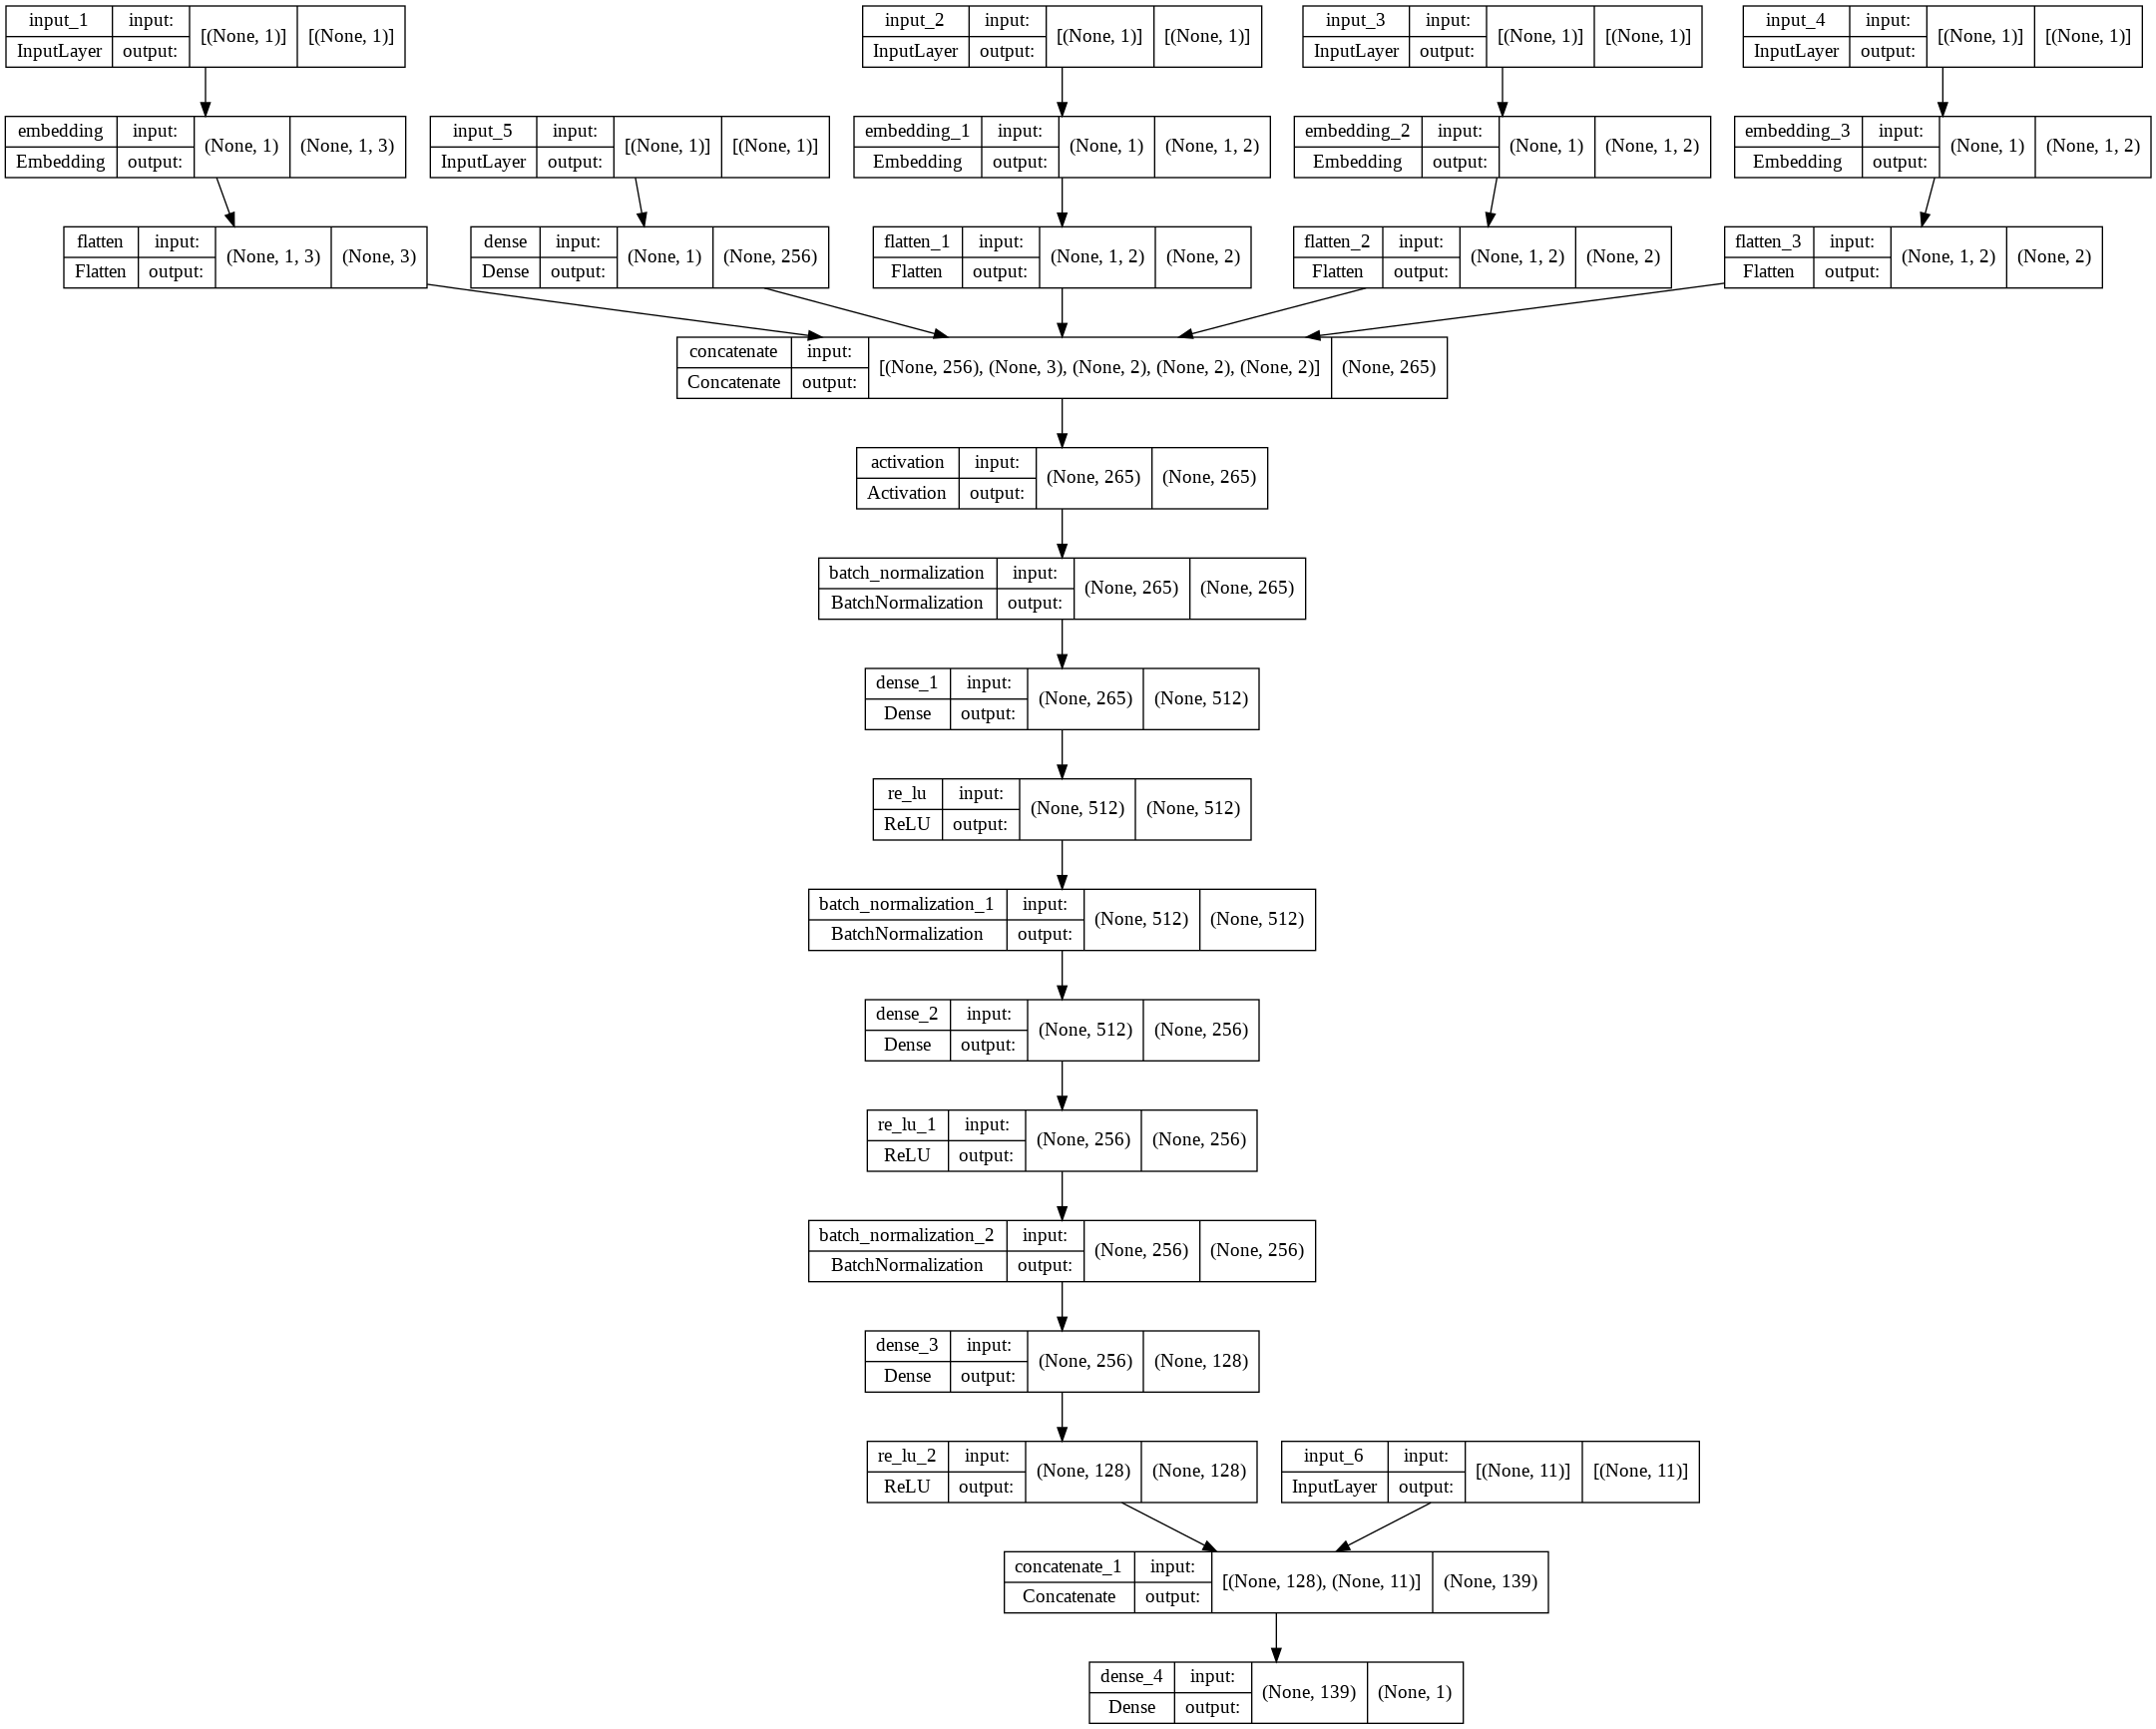

In [ ]:
!pip install pydot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
checkpoint = ModelCheckpoint(filepath='./data/wide-deep.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
################입력데이터###########################

input_data = [X_train_countinue] + [X_train_category[:, i] for i in range(X_train_category.shape[1])] + [X_train_category_poly]


epochs = 30
optimizer ='adam'
batch_size = 128


model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(input_data, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.15, callbacks=[checkpoint, early_stopping])


Epoch 1/30
176/179 [============================>.] - ETA: 0s - loss: 0.5569 - accuracy: 0.7069
Epoch 1: val_loss improved from inf to 0.57906, saving model to ./data/wide-deep.h5
179/179 [==============================] - 5s 15ms/step - loss: 0.5569 - accuracy: 0.7069 - val_loss: 0.5791 - val_accuracy: 0.7057
Epoch 2/30
178/179 [============================>.] - ETA: 0s - loss: 0.5297 - accuracy: 0.7131
Epoch 2: val_loss improved from 0.57906 to 0.56703, saving model to ./data/wide-deep.h5
179/179 [==============================] - 3s 14ms/step - loss: 0.5296 - accuracy: 0.7132 - val_loss: 0.5670 - val_accuracy: 0.7077
Epoch 3/30
176/179 [============================>.] - ETA: 0s - loss: 0.5183 - accuracy: 0.7167
Epoch 3: val_loss improved from 0.56703 to 0.52367, saving model to ./data/wide-deep.h5
179/179 [==============================] - 2s 13ms/step - loss: 0.5186 - accuracy: 0.7167 - val_loss: 0.5237 - val_accuracy: 0.7109
Epoch 4/30
176/179 [============================>.] - ET

In [ ]:
eval_input_data = [X_test_countinue] + [X_test_category[:, i] for i in range(X_test_category.shape[1])] + [X_test_category_poly]

In [ ]:
loss, acc = model.evaluate(eval_input_data, y_test)

360/360 [==============================] - 1s 3ms/step - loss: 0.4994 - accuracy: 0.7289


In [ ]:
print(f'test_loss:{loss} - test_acc:{acc}')

test_loss:0.49939754605293274 - test_acc:0.7289256453514099


In [ ]:
y_test.sum()

3368